# Analyzing the Influenza Dataset

The influenza dataset was downloaded [here](https://www.tycho.pitt.edu/dataset/US.6142004/) from the [Tycho Project](https://www.tycho.pitt.edu) along with the relevant metadata in `data/influenza/US/*`. 



In [1]:
import sys
import pandas

file_loc = 'data/influenza/US/US.6142004.csv'
df = pandas.read_csv(
    file_loc, 
    low_memory=False, 
    parse_dates=['PeriodStartDate', 'PeriodEndDate'], 
    date_parser=lambda x: pandas.datetime.strptime(x, '%Y-%m-%d')
)

We notice a few things about the dataset:

* There is only one PathogenName in the dataset ('unidentified influenza virus')
* There is only one AgeRange in the dataset ('0-130')
* There are no DiagnosisCertainty values ('nan', ('NA)
* The CountValue column is sometimes a "Cummulative" value
  * See the [dataset readme](data/influenza/US/README.txt) under 'Separate cumulative from non-cumulative time interval series'
  * The PartOfCumulativeCountSeries is not provided in this dataset

In [2]:
pandas.unique(df[['PathogenName', 'AgeRange', 'DiagnosisCertainty']].values.ravel('K'))

array(['unidentified influenza virus', '0-130', nan], dtype=object)

## Sanitizing the Dataset
We need to sanitize the dataset to show instance counts in non-overlapping date ranges to make aggregate analysis more simple. To do so, we first see if rows in the dataset actually do contain overlapping date intervals.

### Verifying Overlaps Exist

In [3]:
from src.lib.parse import overlaps, combine_rows

# these are the columns used to determine 
#  if two rows should be checked for overlapping date ranges
# *in order* (least to most specific)
match_on = [
    'Admin1ISO',
    'Admin2Name',
    'CityName',
    'Fatalities'
]

sort_by = ['PeriodStartDate']
found = overlaps(df, match_on, sort_by)
pandas.DataFrame(next(found)[1][1] for i in range(0,3))


,ConditionName,ConditionSNOMED,PathogenName,PathogenTaxonID,Fatalities,CountryName,CountryISO,Admin1Name,Admin1ISO,Admin2Name,CityName,PeriodStartDate,PeriodEndDate,PartOfCumulativeCountSeries,AgeRange,Subpopulation,PlaceOfAcquisition,DiagnosisCertainty,SourceName,CountValue
152524,Influenza,6142004,unidentified influenza virus,11309,0,UNITED STATES OF AMERICA,US,ALABAMA,US-AL,JEFFERSON COUNTY,BIRMINGHAM,1937-05-23,1937-05-29,0,0-130,None specified,NaN,NaN,US Nationally Notifiable Disease Surveillance ...,2
153725,Influenza,6142004,unidentified influenza virus,11309,1,UNITED STATES OF AMERICA,US,ALABAMA,US-AL,JEFFERSON COUNTY,BIRMINGHAM,1937-05-23,1937-05-29,0,0-130,None specified,NaN,NaN,US Nationally Notifiable Disease Surveillance ...,1
99128,Influenza,6142004,unidentified influenza virus,11309,1,UNITED STATES OF AMERICA,US,ALABAMA,US-AL,MOBILE COUNTY,MOBILE,1937-05-23,1937-05-29,0,0-130,None specified,NaN,NaN,US Nationally Notifiable Disease Surveillance ...,0


### Overlapping Data Example

Picking rows in the overlapping dateranges as an example:

In [4]:
mask = (df.CityName == 'NEWARK') &(df.PeriodStartDate >= '1923-11-01') &(df.PeriodStartDate <= '1923-11-15')

df.loc[mask].sort_values(by=['Fatalities', 'PeriodStartDate'])

,ConditionName,ConditionSNOMED,PathogenName,PathogenTaxonID,Fatalities,CountryName,CountryISO,Admin1Name,Admin1ISO,Admin2Name,CityName,PeriodStartDate,PeriodEndDate,PartOfCumulativeCountSeries,AgeRange,Subpopulation,PlaceOfAcquisition,DiagnosisCertainty,SourceName,CountValue
99913,Influenza,6142004,unidentified influenza virus,11309,0,UNITED STATES OF AMERICA,US,NEW JERSEY,US-NJ,ESSEX COUNTY,NEWARK,1923-11-04,1923-11-10,0,0-130,None specified,NaN,NaN,US Nationally Notifiable Disease Surveillance ...,11
99914,Influenza,6142004,unidentified influenza virus,11309,0,UNITED STATES OF AMERICA,US,NEW JERSEY,US-NJ,ESSEX COUNTY,NEWARK,1923-11-05,1923-11-11,0,0-130,None specified,NaN,NaN,US Nationally Notifiable Disease Surveillance ...,7


### Sanitizing Overlapping Rows

As described in the dataset readme:

* Cumulative case count time series consist of overlapping case count intervals starting on the same date, but ending on different dates. 
  * For example, each interval in a cumulative count time series can start on January 1st, but end on January 7th, 14th, 21st, etc. 
  * It is common practice among public health agencies to report cases for cumulative time intervals. 

We find:

* Between `"1923-11-04","1923-11-10"` there were `11` reported non-fatal counts of Influenza in Birmingham.
* Between `"1923-11-05","1923-11-11"` there were `7` reported non-fatal counts of Influenza in Birmingham.


We can only be sure that between `1923-11-04` - `1923-11-11` there were between `[11,18]` (inclusive) counts of influenza recorded in Newark. 


More generally:

* Given possibly overlapping date ranges `[d1, d2], [d3, d4], ...` and instance counts `c1, c2, c3, ...`
* We can be sure in the date range 
  * `[min(d1,d2,d3,...), max(d1,d2,d3,...)]` 
* there are between 
  * `[max(c1,c2,c3...), sum(c1,c2,c3,c4...)]` disease instance counts.*


* We decide to pick the worst case (sum ) of the range - though you could also pick the average or minimum.


In [5]:
to_drop = [combine_rows(prev, cur, df) for prev, cur in overlaps(df, match_on, sort_by)]
df.drop(to_drop, inplace=True)

###### Test and Verify Sanitizing Worked

In [6]:
found = overlaps(df, match_on, sort_by)
try:
    print(next(found))
except StopIteration:
    print("No overlaps found!")

No overlaps found!


# Visualizing The Data

##### Fatal Instances of Influenza

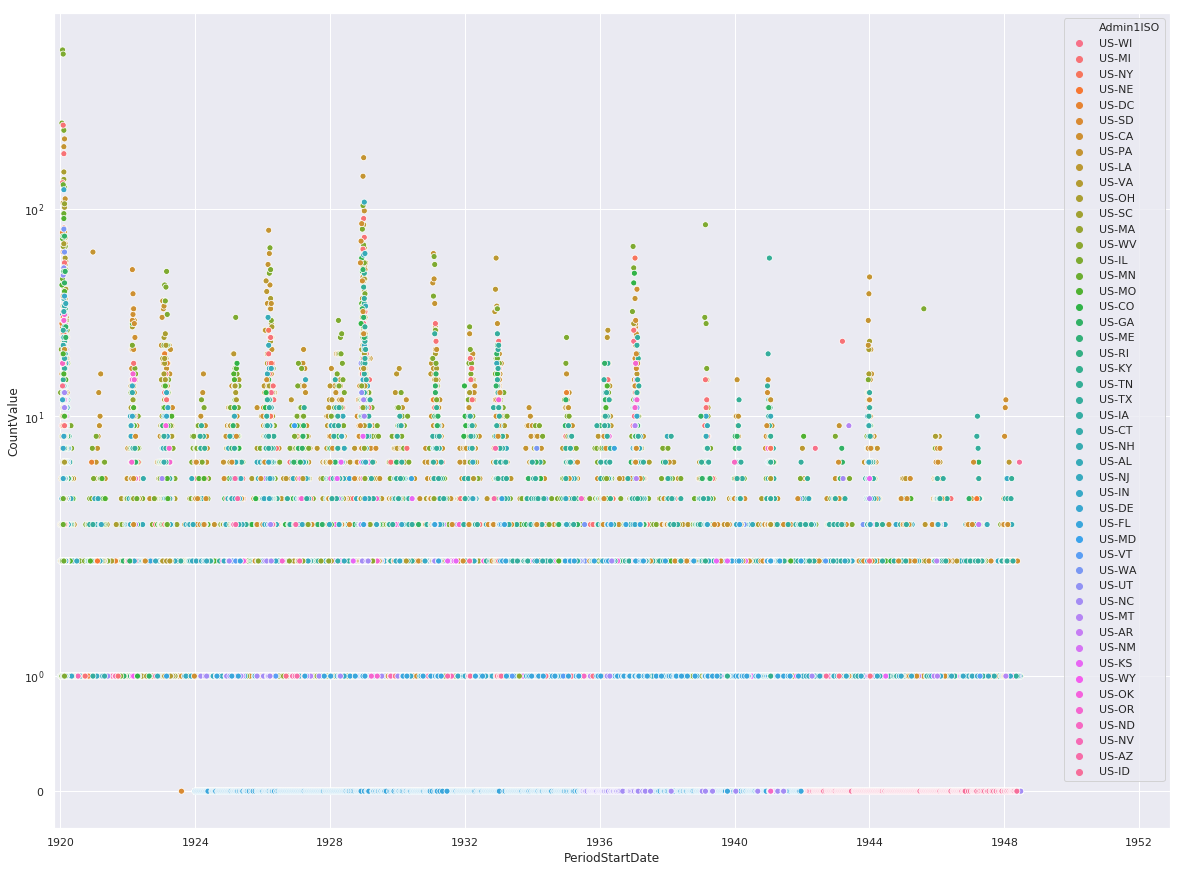

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(20,15)})

ax = sns.scatterplot(
    x='PeriodStartDate', 
    y='CountValue', 
    hue='Admin1ISO', 
    data=df[df.Fatalities == 1]
)

ax.set_yscale('symlog')
ax.set(xlim=(min(df.PeriodStartDate), max(df.PeriodStartDate) + pandas.DateOffset(years=1)))

plt.show()

##### Non-Fatal Instances of Influenza

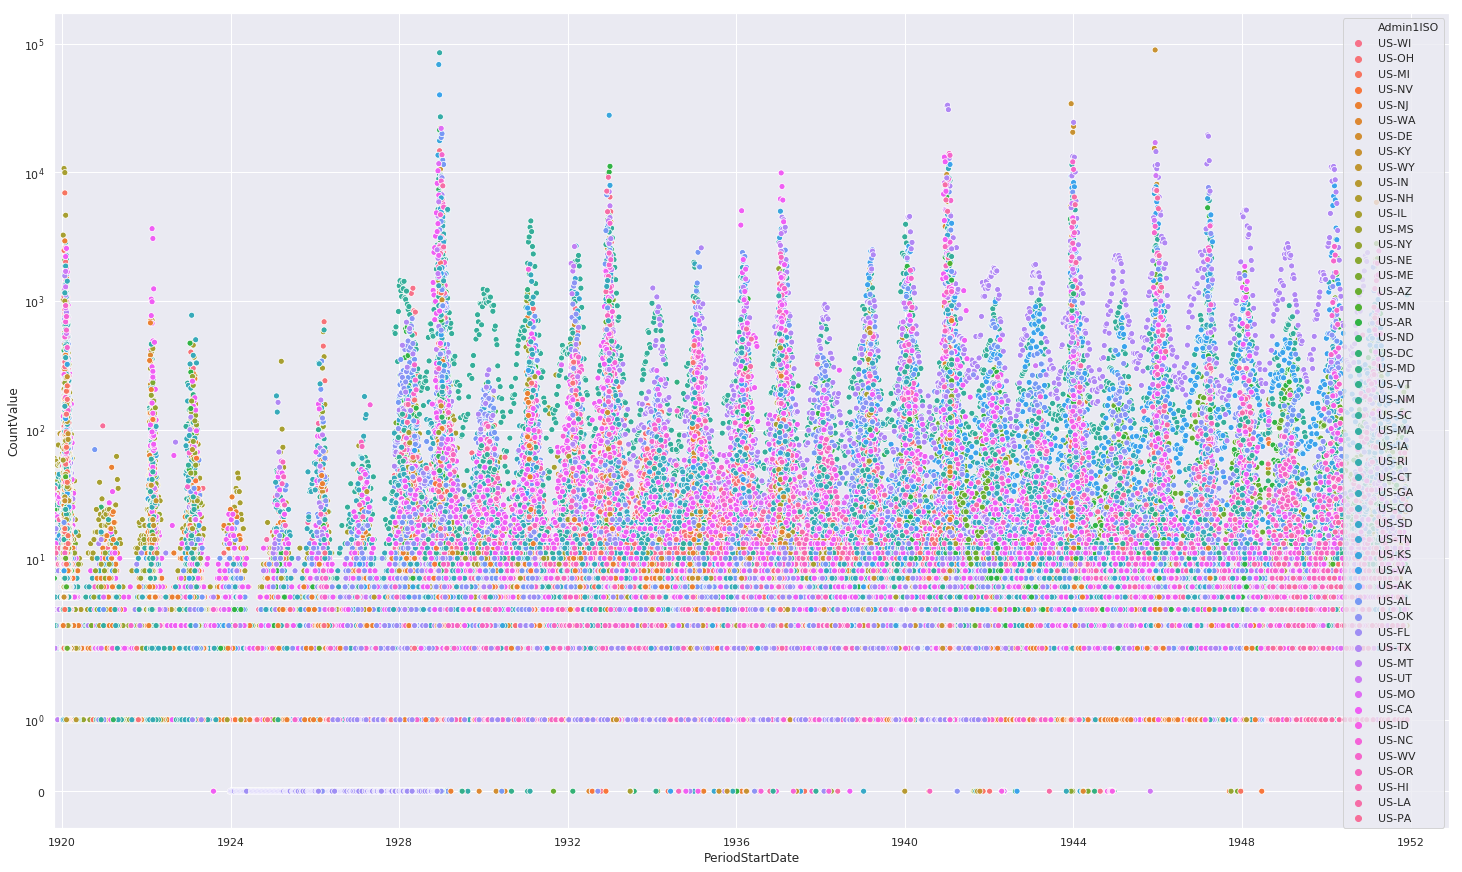

In [8]:
%matplotlib inline

sns.set(rc={'figure.figsize':(25,15)})

ax = sns.scatterplot(
    x='PeriodStartDate', 
    y='CountValue', 
    hue='Admin1ISO', 
    data=df[df.Fatalities == 0]
)

ax.set_yscale('symlog')
ax.set(xlim=(min(df.PeriodStartDate), max(df.PeriodStartDate) + pandas.DateOffset(years=1)))

plt.show()

#####  Combined Fatal and Non-Fatal Instances of Influenza

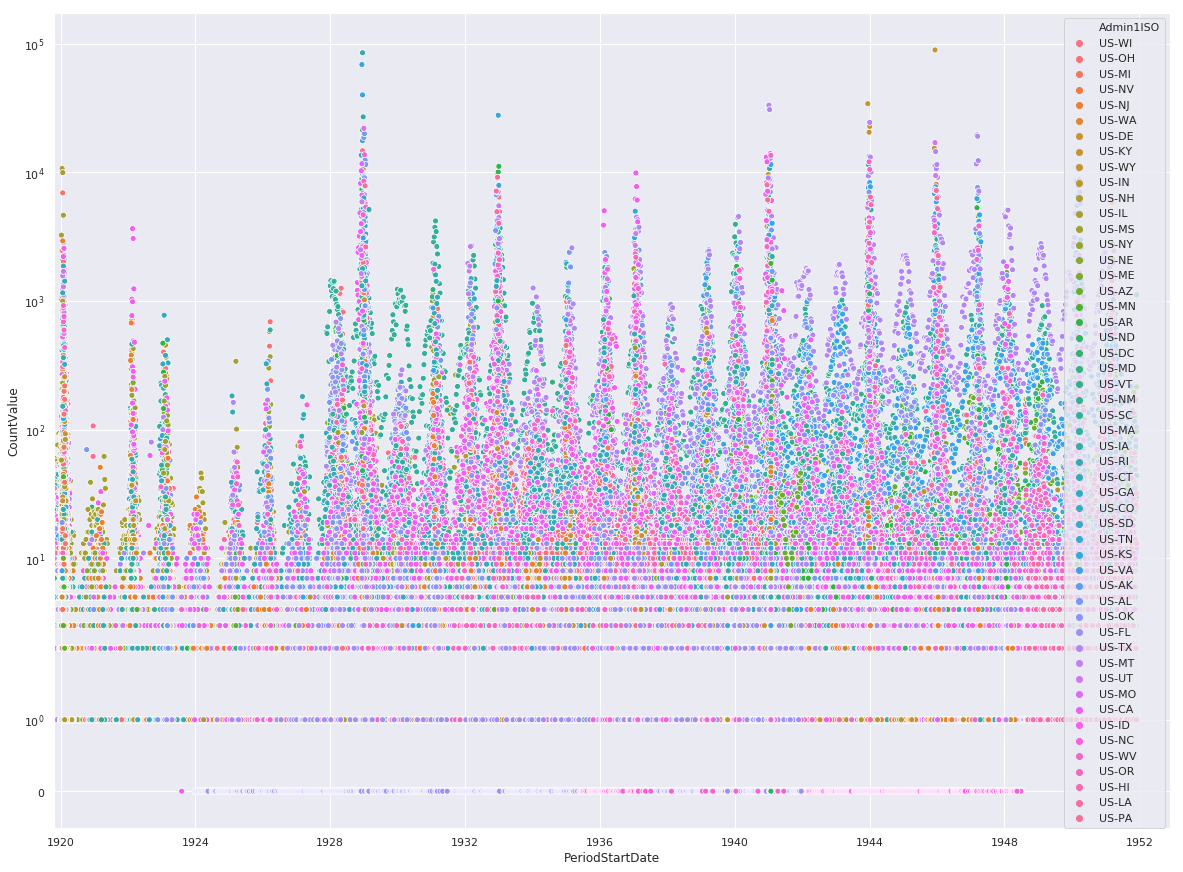

In [11]:
%matplotlib inline

sns.set(rc={'figure.figsize':(20,15)})

ax = sns.scatterplot(
    x='PeriodStartDate', 
    y='CountValue', 
    hue='Admin1ISO', 
    data=df
)

ax.set_yscale('symlog')
ax.set(xlim=(min(df.PeriodStartDate), max(df.PeriodStartDate) + pandas.DateOffset(years=1)))

plt.show()

### Preserving Datapoint Magnitudes

The above scatter plots mask an important piece of information, namely two states with similiar count values will overlap and mask the magnitudes. We can overcome this by using a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

##### Fatal Instances of Influenza Heatmap

We start by pivoting on the state and year, and aggregating on the fatal `CountValue`'s. We will also order the states from east to west geographically.


In [133]:
states_east_to_west = [
    'US-ME', 'US-NH', 'US-VT', 'US-MA', 'US-RI', 'US-CT', 'US-NY', 'US-NJ', 'US-PA', 'US-DE', 'US-MD', 'US-DC',
    'US-WV', 'US-VA', 'US-NC', 'US-SC', 'US-GA', 'US-FL',
    'US-MI', 'US-IN', 'US-OH', 'US-KY', 'US-TN', 'US-AL', 'US-MS',
    'US-WI', 'US-IL', 
    'US-MN', 'US-IA', 'US-MO', 'US-AR', 'US-LA',
    'US-ND', 'US-SD', 'US-NE', 'US-KS', 'US-OK', 'US-TX',
    'US-MT', 'US-WY', 'US-CO', 'US-NM',
    'US-ID', 'US-NV', 'US-UT', 'US-AZ',
    'US-WA', 'US-OR', 'US-CA', 
    'US-HI', 'US-AK'


]

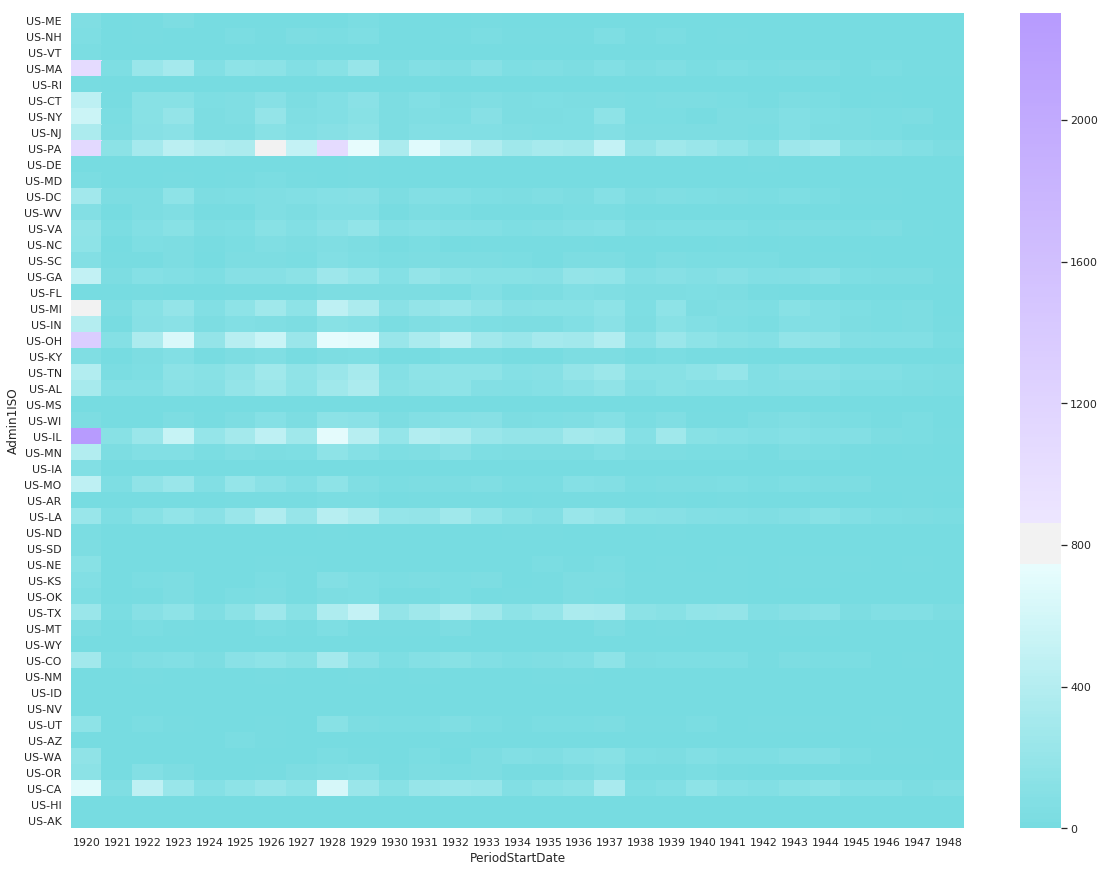

In [203]:
df_pv = df[df.Fatalities == 1].groupby(['Admin1ISO', df['PeriodStartDate'].dt.year])['CountValue'].sum()
df_pv = df_pv.reset_index().pivot('Admin1ISO','PeriodStartDate', 'CountValue').reindex(states_east_to_west, axis=0).fillna(0)

sns.heatmap(
    df_pv, 
    cmap=sns.diverging_palette(200, 275, s=99, l=70, as_cmap=True),
    center=800
)

##### Non-Fatal Instances of Influenza Heatmap

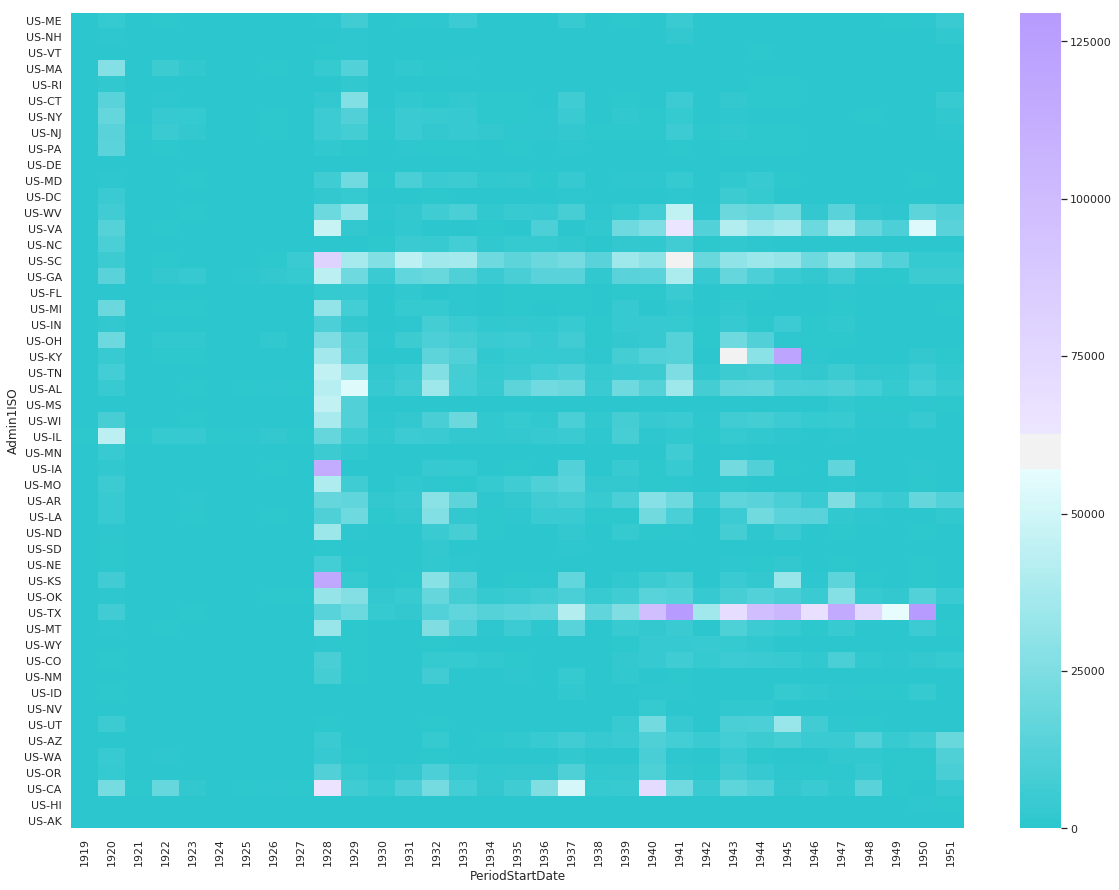

In [205]:
df_pv = df[df.Fatalities == 0].groupby(['Admin1ISO', df['PeriodStartDate'].dt.year])['CountValue'].sum()
df_pv = df_pv.reset_index().pivot('Admin1ISO','PeriodStartDate', 'CountValue').reindex(states_east_to_west, axis=0).fillna(0)

sns.heatmap(
    df_pv, 
    cmap=sns.diverging_palette(200, 275, s=99, l=70, as_cmap=True),
    center=60000
)

##### Combined Fatal and Non-Fatal Instances of Influenza

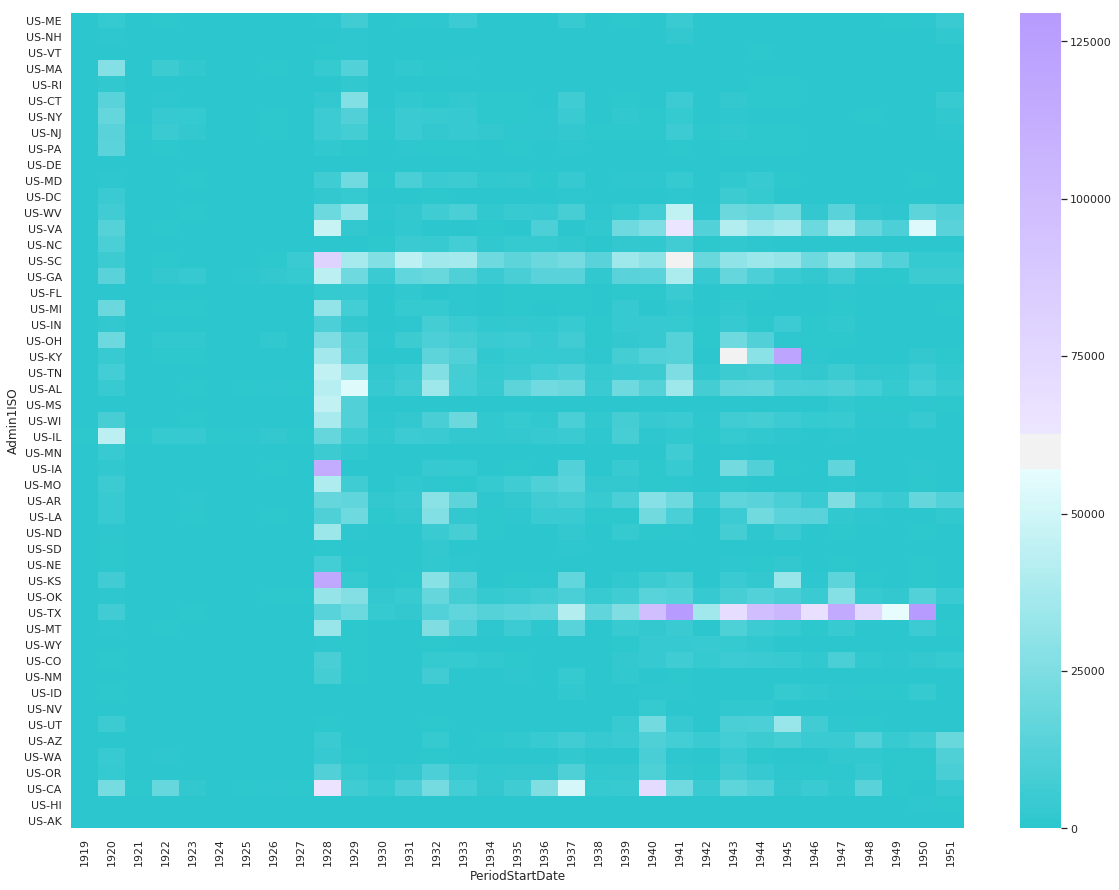

In [206]:
df_pv = df[df.Fatalities == 0].groupby(['Admin1ISO', df['PeriodStartDate'].dt.year])['CountValue'].sum()
df_pv = df_pv.reset_index().pivot('Admin1ISO','PeriodStartDate', 'CountValue').reindex(states_east_to_west, axis=0).fillna(0)

sns.heatmap(
    df_pv, 
    cmap=sns.diverging_palette(200, 275, s=99, l=70, as_cmap=True),
    center=60000
)

######  Code And Other Snippets

In [ ]:
# %load src/lib/parse.py
def between(s, e, d):
    return s <= d <= e


def is_row_between(prev, cur, match_on):
    """ 
        returns if the date range of prev 
        has any overlap 
        with the date range cur
        and if they have matching match_on values
    """
    (_, r1), (_, r2) = prev, cur
    d1 = (r1.PeriodStartDate, r1.PeriodEndDate, r2.PeriodStartDate)
    d2 = (r1.PeriodStartDate, r1.PeriodEndDate, r2.PeriodEndDate)
    return all(r1[m] == r2[m] for m in match_on) and (between(*d1) or between(*d2))


def iter_with_prev(df):
    """ 
        return an iterator that gives back a tuple on next
        ((i, previous_row), (i+1, previous_row))
        first value is ((0, df[0]), (1, df[1]))
    """
    try:
        rows = df.iterrows()
        prev, curr = next(rows), next(rows)
        yield prev, curr
        prev = curr
        for row in rows:
            yield prev, row
            prev = row
    except StopIteration: # could yield back ((1, df[1]), None) ?
        pass


def combine_rows(prev, cur, df): #, r2_i, df
    """
        combines the two rows into r2, drops r_1
            date range is smallest date range that includes r1 & r2
            count is sum(counts) (the worst caste)
                this could be avg, min, max etc.
        returns the index of the previous row
    """
    (r1_i, r1), (r2_i, r2) = prev, cur
    dates = (r1.PeriodStartDate, r1.PeriodEndDate, r2.PeriodStartDate, r2.PeriodEndDate)
    counts = (r1.CountValue, r2.CountValue)
    df.at[r2_i, 'PeriodStartDate'] = min(*dates)
    df.at[r2_i, 'PeriodEndDate'] = max(*dates)
    df.at[r2_i, 'CountValue'] = sum(counts)
    return r1_i


def overlaps(df, match_on, sort_by):
    """
        yields the previous and current row
        given rows to match on, sort by and a data frame
    """
    for prev, curr in iter_with_prev(df.sort_values(by=match_on + sort_by)):
        if is_row_between(prev, curr, match_on):
            yield prev, curr